# Perera Multitask Model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from summit import *
from multitask import *


from botorch.models import MultiTaskGP, SingleTaskGP, MixedSingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import (
    ExactMarginalLogLikelihood,
)

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import torch

import ord_schema
from ord_schema import message_helpers
from ord_schema.proto.dataset_pb2 import *

from rdkit import Chem

import matplotlib.pyplot as plt
from fastprogress import progress_bar
from pathlib import Path
from typing import Iterable
import pandas as pd
import numpy as np
from numpy.random import default_rng
from copy import deepcopy

## Functions

In [80]:
# Transform inputs
def get_ct(continuous_features, ordinal_features):
    transformers = []
    transformers.append(
        (
            "continuous",
            StandardScaler(),
            continuous_features
        )
    )
    if type(ordinal_features) == list:
        transformers.append(
            (
                "ordinal",
                OrdinalEncoder(),
                ordinal_features
            )
        )
    elif type(ordinal_features) == dict:
        categories = [cats for cats in ordinal_features.values()]
        transformers.append(
            (
                "ordinal",
                OrdinalEncoder(categories=categories),
                list(ordinal_features.keys())
            )
        )
    return ColumnTransformer(transformers)

In [60]:
def parity_plot(result: dict, ax: plt.Axes = None):
    # Train resultss
    model = result["model"]
    train_posterior = model.posterior(torch.tensor(result["train_X"]))
    train_y_pred_mean = train_posterior.mean.detach()
    train_y_pred_std = train_posterior.variance.sqrt()
    train_y_pred_mean = result["output_transform"].inverse_transform(train_y_pred_mean)
    train_y = result["output_transform"].inverse_transform(result["train_y"])

    # Plotting
    if ax is None:
        fig, ax = plt.subplots(1)
    ax.plot([0,100], [0,100], "--")
    ax.scatter(train_y, train_y_pred_mean, label="Train")
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    
    if result.get("test_X") is not None and result.get("test_y") is not None:
        test_posterior = model.posterior(torch.tensor(result["test_X"]))
        test_y_pred_mean = test_posterior.mean.detach()
        test_y_pred_std = test_posterior.variance.sqrt()
        test_y_pred_mean = result["output_transform"].inverse_transform(test_y_pred_mean)
        test_y = result["output_transform"].inverse_transform(result["test_y"])
        
        ax.scatter(test_y, test_y_pred_mean, label="Test")

## Load Data

In [4]:
data_path = Path("../data")
perera_suzuki_path = data_path / "perera_suzuki" / "ord"

In [5]:
# Load datasets
perera_datasets = [
    message_helpers.load_message(
        str(path), 
        dataset_pb2.Dataset
    )
    for path in perera_suzuki_path.glob("*.pb")
]

In [6]:
def change_pd_acetate_representation(dataset: Dataset, copy=True):
    if copy:
        dataset = deepcopy(dataset)
    for reaction in dataset.reactions:
        inputs = reaction.inputs
        for inp in inputs:
            components = inputs[inp].components
            for c in components:
                if c is not None:
                    if c.reaction_role == ReactionRole.CATALYST:
                        for id_ in c.identifiers:
                            if id_.type == CompoundIdentifier.SMILES:
                                if "CC(=O)[O-].CC(=O)[O-].[Pd+2]" in id_.value:
                                     id_.value = "CC(=O)O[Pd]OC(=O)C"
    return dataset

In [7]:
# Correct Pd acetate representation
perera_datasets = [
    change_pd_acetate_representation(dataset)
    for dataset in perera_datasets
]

## Create pandas dataframes

In [8]:
perera_df_list = [
    suzuki_reaction_to_dataframe(
        dataset.reactions
    )
    for dataset in perera_datasets
]

In [9]:
approved_ligands = [
    'CC(C)Oc1cccc(OC(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1',
    'COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1',
    'c1ccc(P(c2ccccc2)c2ccccc2)cc1', 
    'CC(C)(C)P(C(C)(C)C)C(C)(C)C',
    'CC1(C)c2cccc(P(c3ccccc3)c3ccccc3)c2Oc2c(P(c3ccccc3)c3ccccc3)cccc21',
    'C1CCC(P(C2CCCCC2)C2CCCCC2)CC1',
    'CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1'
]

In [10]:
perera_df_list = [
    df[df["ligand_smiles"].isin(approved_ligands)]
    for df in perera_df_list
]

In [11]:
perera_df_list = [
    df.fillna("")
    for df in perera_df_list
]

In [148]:
for df in perera_df_list:
    df["ligand_smiles"] = df["ligand_smiles"].apply(Chem.CanonSmiles)  

In [12]:
df = perera_df_list[0]
ligands = df["ligand_smiles"].unique()
print(f"Number of unique ligands in DataSet: {len(ligands)}")
count = 0
for ligand in ligands:
    if ligand in approved_ligands:
        count += 1
print(f"Matching approved ligands: {count}")

Number of unique ligands in DataSet: 6
Matching approved ligands: 6


In [114]:
df["ligand_smiles"].value_counts()

c1ccc(P(c2ccccc2)c2ccccc2)cc1                                         32
COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1                            32
CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1             32
C1CCC(P(C2CCCCC2)C2CCCCC2)CC1                                         32
CC1(C)c2cccc(P(c3ccccc3)c3ccccc3)c2Oc2c(P(c3ccccc3)c3ccccc3)cccc21    32
CC(C)(C)P(C(C)(C)C)C(C)(C)C                                           32
Name: ligand_smiles, dtype: int64

## Ordinal Encoding

### Single-Task 

In [32]:
def train_single_task_model(df, include_continuous=True):
    continuous_features = [
        "catalyst_loading",
        "ligand_ratio",
        "temperature",
        "time"
    ]
    categorical_features = [
        "base_smiles",
        "ligand_smiles",
        "solvent",
    ]
    features = categorical_features
    if include_continuous:
        features += continuous_features
    features.append("yld")
    df = df.copy()[features]

    if include_continuous:
        input_transform = get_ct()
    else:   
        input_transform = OrdinalEncoder()
        
    train_X = input_transform.fit_transform(df)
    output_scaler = StandardScaler()
    train_y = output_scaler.fit_transform(df[["yld"]])

    model = MixedSingleTaskGP(
        train_X=torch.tensor(train_X),
        train_Y=torch.tensor(train_y),
        cat_dims=[0,1,2]
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    
    return {
        "input_transform": input_transform,
        "output_transform": output_scaler,
        "train_X": train_X,
        "train_y": train_y,
        "model": model
    }

In [34]:
# Categorical only
results_categorical_only = [
    train_single_task_model(df, include_continuous=False)
    for df in progress_bar(perera_df_list)
]

In [95]:
# Categorical only
results_categorical_continuous = [
    train_single_task_model(df, include_continuous=True)
    for df in progress_bar(perera_df_list)
]

Text(0.5, 0.98, 'Categorical only')

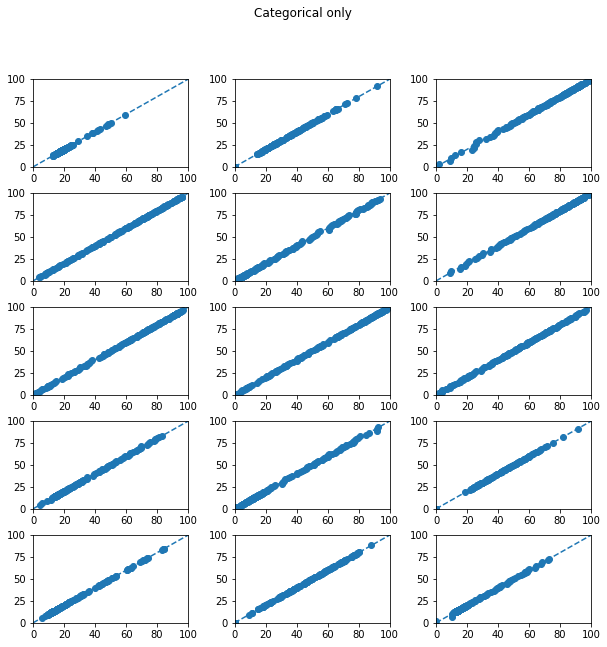

In [35]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for i, result in enumerate(results_categorical_only):
    ax = fig.add_subplot(5,3, i+1)
    parity_plot(result, ax)
fig.suptitle("Categorical only")

Text(0.5, 0.98, 'Categorical + Continuous')

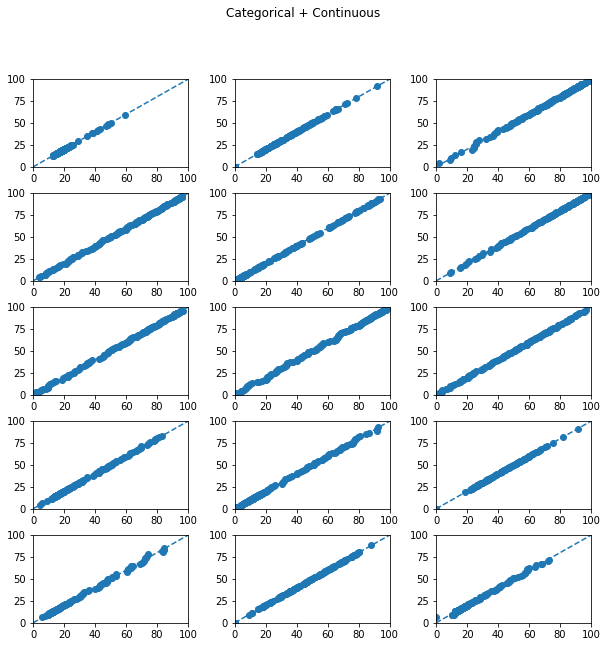

In [97]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for i, result in enumerate(results_categorical_continuous):
    ax = fig.add_subplot(5,3, i+1)
    parity_plot(result, ax)
fig.suptitle("Categorical + Continuous")

### Multi-task

In [40]:
# Parameters
task_number = 1
df = perera_df_list[task_number]
include_continuous=True

# Choose ligand to hold out
rng = default_rng(10)
ligands = df["ligand_smiles"].unique()
hold_out_ligand = rng.choice(ligands)

# Create train and test dataframes
train_df = df[df["ligand_smiles"] != hold_out_ligand]
test_df = df[df["ligand_smiles"] == hold_out_ligand]

# Create multitask train df
train_df = train_df.copy()
train_df["task"] = task_number
for i, co_train_df  in enumerate(perera_df_list):
    if i == task_number:
        continue
    co_train_df = co_train_df.copy()
    co_train_df["task"] = i
    train_df = pd.concat([train_df, co_train_df])

# Preprocessing
categorical_features = [
    "ligand_smiles",
    "base_smiles",
    "solvent",
]
continuous_features = [
    "catalyst_loading",
    "ligand_ratio",
    "temperature",
    "time"
]

features = deepcopy(categorical_features)
if include_continuous:
    features += continuous_features
features.extend(["yld", "task"])
train_df = train_df.copy()[features]

if include_continuous:
    input_transform = get_ct()
else:   
    input_transform = OrdinalEncoder()
    
train_X = input_transform.fit_transform(train_df[categorical_features+continuous_features])
train_X = np.append(train_X, train_df[["task"]], axis=1).astype(
    np.float
)
output_scaler = StandardScaler()
train_y = output_scaler.fit_transform(train_df[["yld"]])


# Train model
model = MixedMultiTaskGP(
    train_X=torch.tensor(train_X),
    train_Y=torch.tensor(train_y),
    task_feature=-1,
    cat_dims=[0,1,2],
    output_tasks=[task_number]
)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-06)
    )
  )
  (model): MixedMultiTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-06)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): AdditiveKernel(
      (kernels): ModuleList(
        (0): ScaleKernel(
          (base_kernel): AdditiveKernel(
            (kernels): ModuleList(
              (0): MaternKernel(
                (raw_lengthscale_constraint): Positive()
                (distance_module): Distance()
              )
              (1): ScaleKernel(
                (base_kernel): CategoricalKernel(
                  (raw_lengthscale_constraint): Positive()
                )
                (raw_outputscale_constraint): Positive()
              )
  

In [ ]:
result = {
    "input_transform": input_transform,
    "output_transform": output_scaler,
    "train_X": train_X[:160, :-1],
    "train_y": train_y[:160],
    "model": model
}

(0.0, 100.0)

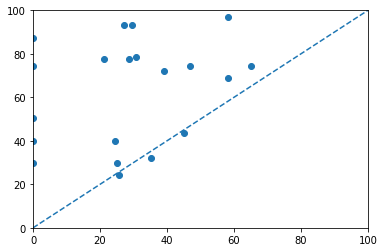

In [41]:
with torch.no_grad():
    train_posterior = model.posterior(torch.tensor(train_X[:160,:-1]))
    train_y_pred_mean = train_posterior.mean.detach()
    train_y_pred_std = train_posterior.variance.sqrt()
train_y_pred_mean = result["output_transform"].inverse_transform(train_y_pred_mean)
t_y = result["output_transform"].inverse_transform(train_y[:160])


# Plotting
fig, ax = plt.subplots(1)
ax.plot([0,100], [0,100], "--")
ax.scatter(t_y, train_y_pred_mean)
ax.set_xlim(0,100)
ax.set_ylim(0,100)

<AxesSubplot:>

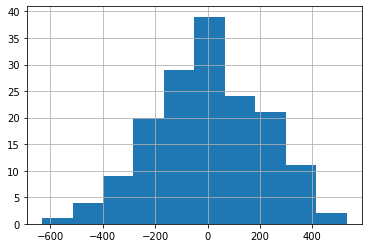

In [39]:
pd.Series(train_y_pred_mean[:,0]).hist()

In [ ]:
input_transform.fit(train_df[categorical_features])
test_X = input_transform.transform(test_df[categorical_features])
output_scaler = StandardScaler()
output_scaler.fit(train_df[["yld"]])
test_y = output_scaler.transform(test_df[["yld"]])

result = {
    "input_transform": input_transform,
    "output_transform": output_scaler,
    "train_X": test_X,
    "train_y": test_y,
    "model": model
}
parity_plot(result)

In [ ]:
# Parameters
df = perera_df_list[0]
include_continuous=False

# Choose ligand to hold out
rng = default_rng(10)
ligands = df["ligand_smiles"].unique()
hold_out_ligand = rng.choice(ligands)

# Create train and test dataframes
train_df = df[df["ligand_smiles"] != hold_out_ligand]
test_df = df[df["ligand_smiles"] == hold_out_ligand]

# Create multitask train df
train_df = train_df.copy()
train_df["task"] = 0
for i, co_train_df  in enumerate(perera_df_list[1:]):
    co_train_df = co_train_df.copy()
    co_train_df["task"] = i+1
    train_df = pd.concat([train_df, co_train_df])

# Preprocessing
categorical_features = [
    "ligand_smiles",
    "base_smiles",
    "solvent",
]
continuous_features = [
    "catalyst_loading",
    "ligand_ratio",
    "temperature",
    "time"
]

features = deepcopy(categorical_features)
if include_continuous:
    features += continuous_features
features.extend(["yld", "task"])
train_df = train_df.copy()[features]

if include_continuous:
    input_transform = get_ct()
else:   
    input_transform = OrdinalEncoder()
    
train_X = input_transform.fit_transform(train_df[categorical_features])
output_scaler = StandardScaler()
train_y = output_scaler.fit_transform(train_df[["yld"]])


# Train model
model = MixedSingleTaskGP(
    train_X=torch.tensor(train_X),
    train_Y=torch.tensor(train_y),
    cat_dims=[0,1,2],
    output_tasks=[0]
)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

## Model with descriptors

### Catalyst Descriptors

In [152]:
lkb = {
    sheet_name: pd.read_excel(
        data_path / "fey_ligand_database.xlsx",
        engine="openpyxl",
        sheet_name=sheet_name,
        skiprows=2
    )
    for sheet_name in ["LKB-P", "LKB-PP"]
}

In [153]:
name_to_smiles = {
    "p(tBu)3": "CC(C)(C)P(C(C)(C)C)C(C)(C)C",
    "P(Ph)3": "c1ccc(P(c2ccccc2)c2ccccc2)cc1",
    "P(Cy)3": "C1CCC(P(C2CCCCC2)C2CCCCC2)CC1",
    "SPhos": "COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1",
    "XPhos": "CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1"
}
smiles_to_name = {v: k for k,v in name_to_smiles.items()}

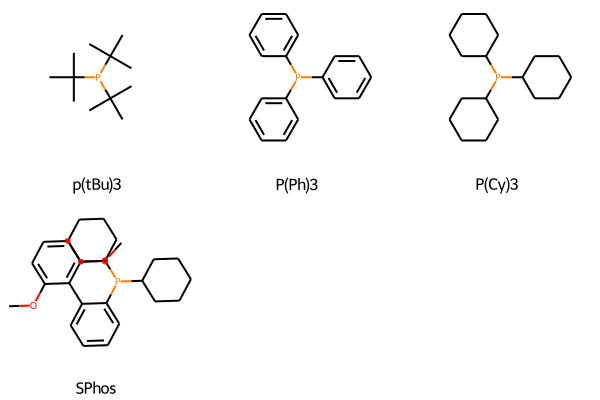

In [154]:
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in df["ligand_smiles"].unique()[:-1]],
    legends = [smiles_to_name[smiles] for smiles in df["ligand_smiles"].unique()[:-1]]
)

The first 4 components explain 84.7% of the variance


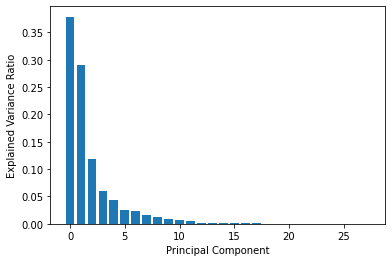

In [155]:
# Principal components
lkb_p = lkb["LKB-P"].set_index("Phosphine Ligand").drop("Ligand No.", axis=1)
lkb_p_norm = (lkb_p - lkb_p.mean())/lkb_p.std()
pca = PCA()
pca.fit(lkb_p_norm)
evr = pca.explained_variance_ratio_
x = np.arange(0, len(evr))
plt.bar(x, evr)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
n = 4
print(f"The first {n} components explain {sum(evr[:n])*100:.1f}% of the variance")

In [156]:
# Create Ligand knowledge base with four principal components 
n=4
lkb_p = lkb["LKB-P"].set_index("Phosphine Ligand").drop("Ligand No.", axis=1)
lkb_p_norm = (lkb_p - lkb_p.mean())/lkb_p.std()
pca = PCA(n_components=n)
lkb_p_pca = pca.fit_transform(lkb_p_norm)
lkb_p_pca = pd.DataFrame(lkb_p_pca, columns=[f"PC_{i}" for i in range(1,n+1)]).set_index(lkb_p.index)

In [157]:
# Create descriptors set
ligand_descriptors = {}
for name, smiles in name_to_smiles.items():
    ligand_descriptors[smiles] = lkb_p_pca.loc[name]
ligand_descriptors = pd.DataFrame(ligand_descriptors)
ligand_descriptors = ligand_descriptors.transpose()
ligand_descriptors.columns

Index(['PC_1', 'PC_2', 'PC_3', 'PC_4'], dtype='object')

In [19]:
# Create combined dataset
perera_df_list_descriptors = [
    df.merge(ligand_descriptors, left_on="ligand_smiles", right_index=True)
    for df in perera_df_list
]

### Visualizations

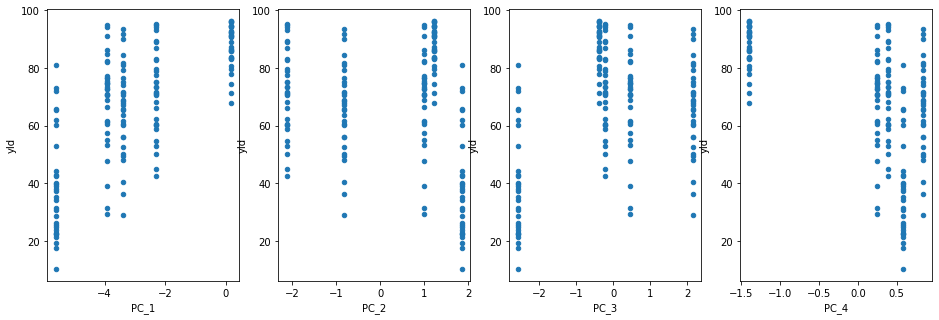

In [108]:
df = perera_df_list_descriptors[3]
fig = plt.figure(figsize=(20,5))
for i in range(1,5):
    col = f"PC_{i}"
    ax = fig.add_subplot(1,5, i)
    df.plot(x=col, y="yld", kind="scatter", ax = ax)

<AxesSubplot:xlabel='base_smiles'>

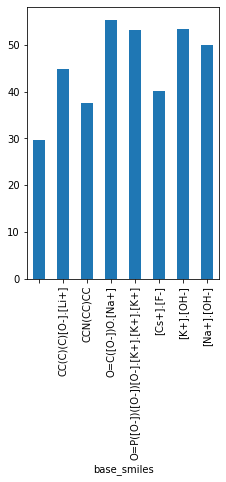

In [124]:
df = perera_df_list_descriptors[13]
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,5, i)
df.groupby("base_smiles")["yld"].mean().plot.bar()

<AxesSubplot:xlabel='solvent'>

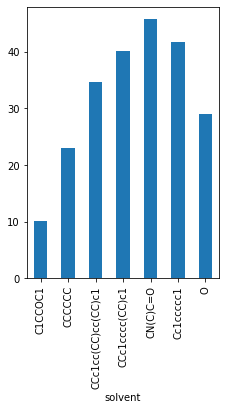

In [127]:
df = perera_df_list_descriptors[4]
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,5, i)
df.groupby("solvent")["yld"].mean().plot.bar()

### Single-task Model 

In [184]:
train_X.shape

(2368, 7)

In [189]:
# Parameters
def train_single_task_model_descriptors(df):
    df = df[df["ligand_smiles"] != "CC1(C)c2cccc(P(c3ccccc3)c3ccccc3)c2Oc2c(P(c3ccccc3)c3ccccc3)cccc21"]
    # Choose ligand to hold out
    rng = default_rng(10)
    ligands = df["ligand_smiles"].unique()
    hold_out_ligand = rng.choice(ligands)

    # Create train and test dataframes
    train_df = df[df["ligand_smiles"] != hold_out_ligand]
    test_df = df[df["ligand_smiles"] == hold_out_ligand]

    # Preprocessing
    ordinal_features = {
        "base_smiles": df["base_smiles"].unique(),
        "solvent": df["solvent"].unique()
    }
    # continuous_features = [
    #     "catalyst_loading",
    #     "ligand_ratio",
    #     "temperature",
    #     "time"
    # ]
    continuous_features = [f"PC_{i}" for i in range(1,5)]
    
    input_transform = get_ct(
        continuous_features=continuous_features, ordinal_features=ordinal_features
    )
    ordinal_features_list = list(ordinal_features.keys())
    features = ordinal_features_list + continuous_features

    train_X = input_transform.fit_transform(train_df[features])
    test_X = input_transform.transform(test_df[features])
    output_scaler = StandardScaler()
    train_y = output_scaler.fit_transform(train_df[["yld"]])
    test_y = output_scaler.transform(test_df[["yld"]])


    # Train model
    cat_dims = np.arange(len(ordinal_features))
    model = MixedSingleTaskGP(
        train_X=torch.tensor(train_X),
        train_Y=torch.tensor(train_y),
        cat_dims=[4,5],
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    return {
            "input_transform": input_transform,
            "output_transform": output_scaler,
            "train_X": train_X,
            "train_y": train_y,
            "test_X": test_X,
            "test_y": test_y,
            "model": model
    }

In [191]:
res = train_single_task_model_descriptors(perera_df_list_descriptors[0])

In [186]:
results_st_descriptors = [
    train_single_task_model_descriptors(df)
    for df in progress_bar(perera_df_list_descriptors)
]

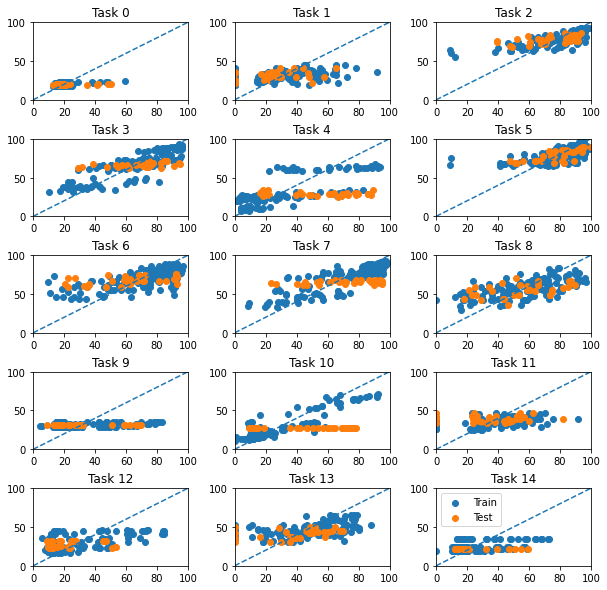

In [187]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
for i, result in enumerate(results_st_descriptors):
    ax = fig.add_subplot(5,3, i+1)
    parity_plot(result, ax)
    ax.set_title(f"Task {i}")
ax.legend()

### Multi-task Model

In [194]:
def train_multi_task_model_descriptors(df):
    ignore_ligand = "CC1(C)c2cccc(P(c3ccccc3)c3ccccc3)c2Oc2c(P(c3ccccc3)c3ccccc3)cccc21"
    df = df[df["ligand_smiles"] != ignore_ligand]
    # Choose ligand to hold out
    rng = default_rng(10)
    ligands = df["ligand_smiles"].unique()
    hold_out_ligand = rng.choice(ligands)

    # Create train and test dataframes
    train_df = df[df["ligand_smiles"] != hold_out_ligand]
    test_df = df[df["ligand_smiles"] == hold_out_ligand]

    # Multitask
    train_df = train_df.copy()
    train_df["task"] = task_number
    for i, co_train_df  in enumerate(perera_df_list_descriptors):
        if i == task_number:
            continue
        co_train_df = co_train_df[co_train_df["ligand_smiles"] != ignore_ligand]
        co_train_df = co_train_df.copy()
        co_train_df["task"] = i
        train_df = pd.concat([train_df, co_train_df])

    # Preprocessing
    ordinal_features = {
        "base_smiles": train_df["base_smiles"].unique(),
        "solvent": train_df["solvent"].unique()
    }
    # continuous_features = [
    #     "catalyst_loading",
    #     "ligand_ratio",
    #     "temperature",
    #     "time"
    # ]
    continuous_features = [f"PC_{i}" for i in range(1,5)]
    
    input_transform = get_ct(
        continuous_features=continuous_features, ordinal_features=ordinal_features
    )
    ordinal_features_list = list(ordinal_features.keys())
    features = ordinal_features_list + continuous_features

    train_X = input_transform.fit_transform(train_df[features])
    test_X = input_transform.transform(test_df[features])
    train_X = np.append(train_X, train_df[["task"]], axis=1).astype(
        np.float
    )
    output_scaler = StandardScaler()
    train_y = output_scaler.fit_transform(train_df[["yld"]])
    test_y = output_scaler.transform(test_df[["yld"]])


    # Train model
    model = MixedMultiTaskGP(
        train_X=torch.tensor(train_X),
        train_Y=torch.tensor(train_y),
        task_feature=-1,
        cat_dims=[4,5],
        output_tasks=[task_number]
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    return {
        "input_transform": input_transform,
        "output_transform": output_scaler,
        "train_X": train_X[:160,:-1],
        "train_y": train_y[:160],
        "test_X": test_X,
        "test_y": test_y,
        "model": model
    }

In [195]:
results_mt_descriptors = [
    train_multi_task_model_descriptors(df)
    for df in progress_bar(perera_df_list_descriptors)
]

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecation

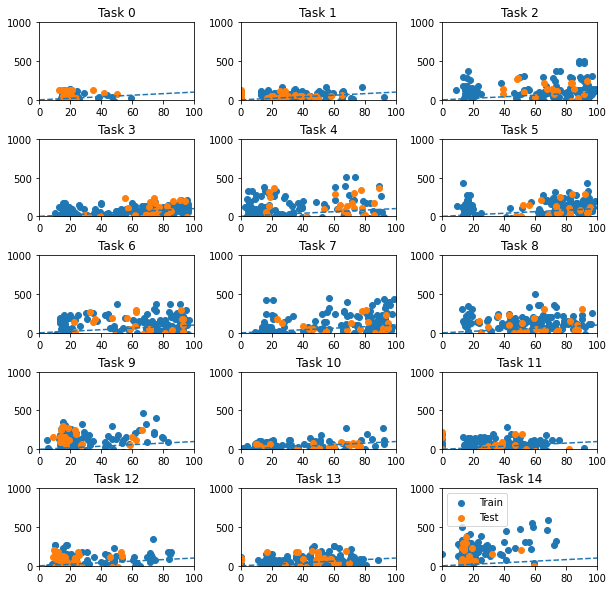

In [196]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
for i, result in enumerate(results_mt_descriptors):
    ax = fig.add_subplot(5,3, i+1)
    parity_plot(result, ax)
    ax.set_title(f"Task {i}")
    ax.set_ylim(0,1000)
ax.legend()


## Experimental Emulator